In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from pure_ldp.frequency_oracles.direct_encoding import DEClient


In [3]:
# Cargar datos
data_path = '../data/raw/bank-full.csv'
df = pd.read_csv(data_path, sep=';')
df['y'] = df['y'].map({'no': 0, 'yes': 1})
X = df.drop(columns=['y'])
y = df['y']

# Mejores parámetros encontrados
best_params_rf = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [4]:

# Función para mapear variables categóricas binarias y meses
def map_binary_columns(df):
    df['default'] = df['default'].map({'no': 0, 'yes': 1})
    df['housing'] = df['housing'].map({'no': 0, 'yes': 1})
    df['loan'] = df['loan'].map({'no': 0, 'yes': 1})
    df['month'] = df['month'].map({
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
        'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
        'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    })
    return df

# Función para convertir variables numéricas en categóricas
def convert_numerics_to_categories(df):
    # age
    bins_age = [18, 30, 40, 50, 60, 95]
    labels_age = ['18-30', '31-40', '41-50', '51-60', '61+']
    df['age'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, include_lowest=True)

    # balance
    bins_balance = [-8019, 0, 72, 448, 1428, 102127]
    labels_balance = ['negative', '0-72', '73-448', '449-1428', '1429+']
    df['balance'] = pd.cut(df['balance'], bins=bins_balance, labels=labels_balance, include_lowest=True)

    # day
    bins_day = [1, 7, 14, 21, 31]
    labels_day = ['1-7', '8-14', '15-21', '22-31']
    df['day'] = pd.cut(df['day'], bins=bins_day, labels=labels_day, include_lowest=True)

    # duration
    bins_duration = [0, 103, 180, 319, 4918]
    labels_duration = ['0-103', '104-180', '181-319', '320+']
    df['duration'] = pd.cut(df['duration'], bins=bins_duration, labels=labels_duration, include_lowest=True)

    # campaign
    bins_campaign = [1, 2, 3, 10, 63]  # Ajustado para evitar duplicados
    labels_campaign = ['1', '2-3', '4-10', '11+']
    df['campaign'] = pd.cut(df['campaign'], bins=bins_campaign, labels=labels_campaign, include_lowest=True)

    # pdays
    bins_pdays = [-1, 0, 30, 90, 871]  # Ajustado para evitar duplicados
    labels_pdays = ['no_contact', '0-30', '31-90', '91+']
    df['pdays'] = pd.cut(df['pdays'], bins=bins_pdays, labels=labels_pdays, include_lowest=True)

    # previous
    bins_previous = [0, 1, 2, 5, 275]  # Ajustado para evitar duplicados
    labels_previous = ['0', '1-2', '3-5', '6+']
    df['previous'] = pd.cut(df['previous'], bins=bins_previous, labels=labels_previous, include_lowest=True)

    return df

# Función para mapear variables categóricas a valores numéricos
def map_categorical_columns(df, categorical_columns):
    mappings = {}
    for col in categorical_columns:
        unique_values = df[col].unique()
        mappings[col] = {value: idx for idx, value in enumerate(unique_values) if pd.notna(value)}
        df[col] = df[col].map(mappings[col])
    return df, mappings

# Función para aplicar DE con Direct Encoding
def apply_de(df, epsilon, categorical_columns):
    df_de = df.copy()
    for col in categorical_columns:
        de = DEClient(epsilon=epsilon, d=df[col].nunique())
        df_de[col] = df_de[col].apply(lambda x: de.privatise(int(x)))
    return df_de

# Procesamiento completo
def process_data(X, y, categorical_columns, apply_DE=False, epsilon=None):
    x = X.copy()
    if apply_DE and epsilon:
        x = apply_de(x, epsilon, categorical_columns)

    # One-Hot Encoding (OHE)
    x = pd.get_dummies(x, columns=categorical_columns, drop_first=True, dtype='int64')

    # Split train-test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    # No se necesita escalado porque todas las columnas son categóricas

    # Aplicar SMOTEENN para balancear clases
    smoteenn = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

    # Selección de características con Boruta
    rf = RandomForestClassifier(**best_params_rf, random_state=42)
    boruta = BorutaPy(rf, n_estimators='auto', verbose=0)
    boruta.fit(X_train_resampled.values, y_train_resampled.values)
    selected_features = X_train_resampled.columns[boruta.support_].tolist()
    return X_train_resampled[selected_features], X_test[selected_features], y_train_resampled, y_test

# Entrenar y evaluar modelo
def evaluate_model(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(**best_params_rf, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    conf_matrix = confusion_matrix(y_test, y_pred)
    actual_negatives, actual_positives = conf_matrix[0].sum(), conf_matrix[1].sum()
    false_positive_pct = conf_matrix[0][1] / actual_negatives if actual_negatives > 0 else 0
    false_negative_pct = conf_matrix[1][0] / actual_positives if actual_positives > 0 else 0
    return {
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Type I Error': false_positive_pct,
        'Type II Error': false_negative_pct
    }

In [5]:
# Todas las columnas son ahora categóricas
all_categorical_columns = ['default', 'housing', 'loan', 'job', 'marital', 'education', 'contact', 'poutcome',
                           'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Epsilons y resultados
epsilons = [5, 1, 0.5, 0.1]
results = {}

In [6]:
# Preprocesar datos originales
X = map_binary_columns(X)
X = convert_numerics_to_categories(X)
X, cat_mappings = map_categorical_columns(X, all_categorical_columns)

In [7]:
# Modelo sin privacidad
X_train, X_test, y_train, y_test = process_data(X, y, all_categorical_columns)
results['Original'] = evaluate_model(X_train, y_train, X_test, y_test)

In [8]:
# Modelos con Direct Encoding
for epsilon in epsilons:
    X_train_de, X_test_de, y_train_de, y_test_de = process_data(X, y, all_categorical_columns, apply_DE=True, epsilon=epsilon)
    results[f'DE (ε={epsilon})'] = evaluate_model(X_train_de, y_train_de, X_test_de, y_test_de)

# Resultados
results_df = pd.DataFrame(results)
print(results_df)

               Original  DE (ε=5)  DE (ε=1)  DE (ε=0.5)  DE (ε=0.1)
ROC AUC        0.852700  0.863735  0.731219    0.817975    0.845281
Accuracy       0.759216  0.735255  0.469331    0.634326    0.700162
Precision      0.307123  0.292353  0.167142    0.228433    0.267908
Recall         0.831039  0.877972  0.879850    0.884856    0.891740
F1 Score       0.448497  0.438643  0.280919    0.363123    0.412028
Type I Error   0.250376  0.283804  0.585492    0.399131    0.325422
Type II Error  0.168961  0.122028  0.120150    0.115144    0.108260


<Figure size 1200x600 with 0 Axes>

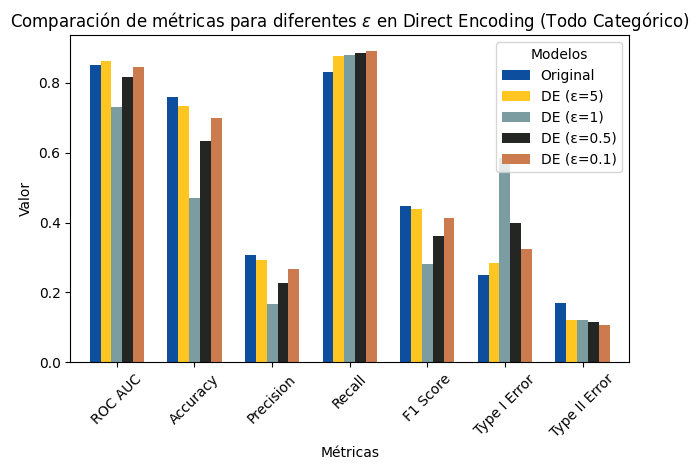

In [9]:
# Gráficas
colores = ['#0d4e9e', '#ffc520', '#7b9ca0', '#242624', '#cc7b4f']
plt.figure(figsize=(12, 6))
ax = results_df.plot(kind='bar', width=0.7, color=colores)
plt.title('Comparación de métricas para diferentes $\epsilon$ en Direct Encoding (Todo Categórico)')
plt.xlabel('Métricas')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.legend(title='Modelos')
plt.tight_layout()
plt.show()